# Model

## Start Spark Session

In [1]:
import boto3
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql import Window

spark = SparkSession.builder \
    .appName("BackTesting") \
    .getOrCreate()

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.7 
Trying to create a Glue session for the kernel.
Session Type: etl
Session ID: 71c82acc-8155-48d4-a521-6888e377689c
Applying the following default arguments:
--glue_kernel_version 1.0.7
--enable-glue-datacatalog true
Waiting for session 71c82acc-8155-48d4-a521-6888e377689c to get into ready status...
Session 71c82acc-8155-48d4-a521-6888e377689c has been created.



In [2]:
%session_id

Current active Session ID: 71c82acc-8155-48d4-a521-6888e377689c


## Set up Model

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, lag, year, lead
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

### Import data from s3 bucket

In [3]:
bucket_name = "crypto-marketdata-marketdatabucket-m13jkiz8o4p7"
btc_processed_file_path = "s3://{}/marketdata/processed_crypto/BTCUSDT-*-processed.parquet".format(bucket_name)

In [4]:
# load processed data
btc_processed_data = spark.read.parquet(btc_processed_file_path)
btc_processed_data = btc_processed_data.orderBy("close_time")

In [5]:
window = Window.orderBy("close_time")
btc_data_with_label = btc_processed_data.withColumn("Next_Close", F.lead("close").over(window))

In [6]:
# Drop rows with null values
btc_data_with_label = btc_data_with_label.dropna()

### Linear regression

In [7]:
class Linear_Regression:
    def __init__(self, features, label_col="Next_Close", max_iter=10):
        self.features = features
        self.label_col = label_col
        self.max_iter = max_iter
        self.model = None

    def prepare_data(self, df, seed=4651):
        assembler = VectorAssembler(inputCols=self.features, outputCol="features")
        data = assembler.transform(df).select("close_time", "features", self.label_col)
        train_data, test_data = data.randomSplit([0.8, 0.2], seed=4651)
        return train_data, test_data

    def train_model(self, train_data):
        lr = LinearRegression(labelCol=self.label_col, maxIter=self.max_iter)
        self.model = lr.fit(train_data)

    def predict(self, test_data):
        if self.model is None:
            raise Exception("Model has not been trained yet.")
        predictions = self.model.transform(test_data)
        return predictions

    def get_coefficients(self):
        if self.model is None:
            raise Exception("Model has not been trained yet.")
        return self.model.coefficients, self.model.intercept

In [8]:
features = ['open', 'high', 'low', 'vol', 'quote_asset_vol', 
            'number_of_trades', 'taker_base_asset_vol', 
            'taker_quote_asset_vol', 'SMA_240', 'SMA_480', 'RSI', 
            'Middle_Band', "STD", "Upper_Band", "Lower_Band"]

linear_regression = Linear_Regression(features)
train_data, test_data = linear_regression.prepare_data(btc_data_with_label)

In [9]:
linear_regression.train_model(train_data)

In [10]:
predictions = linear_regression.predict(test_data)

### Random Forest

In [11]:
class Random_Forest:
    def __init__(self, features, label_col="Next_Close", num_tree=100):
        self.features = features
        self.label_col = label_col
        self.num_tree = num_tree
        self.model = None

    def prepare_data(self, df, seed=4651):
        assembler = VectorAssembler(inputCols=self.features, outputCol="features")
        data = assembler.transform(df).select("close_time", "features", self.label_col)
        train_data, test_data = data.randomSplit([0.8, 0.2], seed=4651)
        return train_data, test_data

    def train_model(self, train_data):
        rf = RandomForestRegressor(labelCol=self.label_col, numTrees=self.num_tree)
        self.model = rf.fit(train_data)

    def predict(self, test_data):
        if self.model is None:
            raise Exception("Model has not been trained yet.")
        predictions = self.model.transform(test_data)
        return predictions

In [12]:
features = ['open', 'high', 'low', 'vol', 'quote_asset_vol', 
            'number_of_trades', 'taker_base_asset_vol', 
            'taker_quote_asset_vol', 'SMA_240', 'SMA_480', 'RSI', 
            'Middle_Band', "STD", "Upper_Band", "Lower_Band"]

random_forest = Random_Forest(features)
train_data_rf, test_data_rf = random_forest.prepare_data(btc_data_with_label)

In [13]:
random_forest.train_model(train_data_rf)

In [14]:
predictions_rf = random_forest.predict(test_data_rf)

## Backtesting

In [15]:
def backtest_strategy(spark_df, strategy_func, initial_capital=100000):
    """
    Backtests a trading strategy on historical data using Spark DataFrame.

    Parameters:
    - spark_df (DataFrame): The historical price data with necessary columns.
    - strategy_func (callable): A function that implements the trading strategy.
    - initial_capital (float): The starting capital for the backtest.

    Returns:
    - DataFrame: A Spark DataFrame containing the results of the backtest.
    """
    
    cash = initial_capital
    shares = 0

    signals_df = strategy_func(spark_df)

    results = []

    for row in signals_df.collect():
        date = row['close_time']
        price = row['close']
        action = row['signal']

        # Buy signal
        if action == 'buy' and cash > 0:
            shares_to_buy = int(cash // price)
            if shares_to_buy > 0:
                cash -= shares_to_buy * price
                shares += shares_to_buy
                results.append((date, 'buy', price, shares_to_buy, cash, cash + shares * price))

        # Sell signal
        elif action == 'sell' and shares > 0:
            cash += shares * price
            results.append((date, 'sell', price, shares, cash, cash))
            shares = 0

    # Final value of the portfolio
    final_value = cash + shares * price
    results.append((date, 'end', price, shares, cash, final_value))

    results_df = spark.createDataFrame(results, ['Date', 'Action', 'Price', 'Shares', 'Cash', 'Total'])

    return results_df

In [16]:
def summarize_backtest_results(results_df):
    """
    Summarizes the results of the backtest.

    Parameters:
    - results_df (DataFrame): A Spark DataFrame containing the backtest results.

    Returns:
    - dict: A dictionary with summarized metrics.
    """
    
    # Initialize variables to track total profit/loss and trade counts
    total_profit_loss = 0
    winning_trades = 0
    losing_trades = 0
    
    buy_prices = []
    shares = []

    for row in results_df.collect():
        action = row['Action']
        price = row['Price']
        shares_count = row['Shares'] if 'Shares' in row else 0
        
        if action == 'buy':
            # Record the buy price and number of shares
            buy_prices.append(price)
            shares.append(shares_count)
        
        elif action == 'sell' and buy_prices:
            # Calculate profit/loss for the last buy
            buy_price = buy_prices.pop()  # Last buy price
            shares_count = shares.pop()  # Last shares bought
            
            profit_loss = (price - buy_price) * shares_count
            total_profit_loss += profit_loss
            
            if profit_loss > 0:
                winning_trades += 1
            else:
                losing_trades += 1

    total_trades = winning_trades + losing_trades

    win_loss_ratio = winning_trades / losing_trades if losing_trades > 0 else float('inf')

    summary = {
        "Total Trades": total_trades,
        "Total Profit/Loss": total_profit_loss,
        "Winning Trades": winning_trades,
        "Losing Trades": losing_trades,
        "Win/Loss Ratio": win_loss_ratio,
        "Average Profit/Loss per Trade": total_profit_loss / total_trades if total_trades > 0 else 0
    }

    return summary

In [17]:
import pandas as pd

def plot_btc_trades(spark_df, results_df):
    """
    Plots the BTC price along with buy and sell signals.

    Parameters:
    - spark_df: Spark DataFrame containing BTC price data.
    - results_df: Spark DataFrame containing trading results with buy/sell signals.
    """
    btc_df = spark_df.toPandas()
    results_pd = results_df.toPandas()
    
    plt.figure(figsize=(14, 7))
    plt.plot(btc_df['close_time'], btc_df['close'], label='BTC Closing Price', color='black', alpha=0.6)

    # Mark buy trades
    buy_trades = results_pd[results_pd['Action'] == 'buy']
    plt.scatter(buy_trades['Date'], buy_trades['Price'], marker='^', color='green', label='Buy Signal', s=100)

    # Mark sell trades
    sell_trades = results_pd[results_pd['Action'] == 'sell']
    plt.scatter(sell_trades['Date'], sell_trades['Price'], marker='v', color='red', label='Sell Signal', s=100)

    plt.title('BTC Price with Buy and Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    
    plt.show()

### Strategies

In [18]:
def simple_moving_average_strategy(spark_df, short_window=240, long_window=480):
    """
    A simple moving average crossover strategy using Spark.

    Parameters:
    - spark_df (DataFrame): The historical price data.
    - short_window (int): The short moving average window.
    - long_window (int): The long moving average window.

    Returns:
    - DataFrame: A Spark DataFrame with buy/sell signals.
    """
    # Calculate short and long moving averages
    spark_df = spark_df.withColumn('SMA_short', F.avg('close').over(Window.orderBy('close_time').rowsBetween(-short_window + 1, 0)))
    spark_df = spark_df.withColumn('SMA_long', F.avg('close').over(Window.orderBy('close_time').rowsBetween(-long_window + 1, 0)))

    # Generate signals
    spark_df = spark_df.withColumn('signal', 
        F.when(F.col('SMA_short') > F.col('SMA_long'), 'buy')
         .when(F.col('SMA_short') < F.col('SMA_long'), 'sell')
         .otherwise(None))

    return spark_df.select('close_time', 'close', 'signal')

In [19]:
def vwap_strategy(spark_df):
    """
    A Volume Weighted Average Price (VWAP) strategy using Spark.

    Parameters:
    - spark_df (DataFrame): The historical price data.

    Returns:
    - DataFrame: A Spark DataFrame with buy/sell signals.
    """
    # Calculate cumulative sum of price * volume and cumulative volume
    spark_df = spark_df.withColumn('price_volume', F.col('close') * F.col('vol'))
    cumsum_df = spark_df.select(
        'close_time',
        'close',
        'vol',
        F.sum('price_volume').over(Window.orderBy('close_time').rowsBetween(Window.unboundedPreceding, Window.currentRow)).alias('cumulative_price_volume'),
        F.sum('vol').over(Window.orderBy('close_time').rowsBetween(Window.unboundedPreceding, Window.currentRow)).alias('cumulative_volume')
    )

    # Calculate VWAP
    cumsum_df = cumsum_df.withColumn('VWAP', F.col('cumulative_price_volume') / F.col('cumulative_volume'))

    # Generate signals
    cumsum_df = cumsum_df.withColumn('signal', 
        F.when(F.col('close') > F.col('VWAP'), 'buy')
         .when(F.col('close') < F.col('VWAP'), 'sell')
         .otherwise(None))

    return cumsum_df.select('close_time', 'close', 'VWAP', 'signal')

In [20]:
def ML_prediction_strategy(spark_df):
    """
    A strategy that uses the prediction result of the ML model
    to generate buy/sell signals.

    Parameters:
    - spark_df (DataFrame): The historical price data.

    Returns:
    - DataFrame: A Spark DataFrame with buy/sell signals.
    """
    entry_threshold = 0
    exit_threshold = -0

    spark_df = spark_df.withColumn("price_diff", (col("prediction") - col("close")) / col("close"))

    # Generate signals
    spark_df = spark_df.withColumn("signal",
                   F.when(col("price_diff") > entry_threshold, "buy")
                    .when(col("price_diff") < -exit_threshold, "sell")
                    .otherwise("hold"))

    return spark_df.select('close_time', 'close', 'signal')

### Implication

#### Simple moving average strategy

In [21]:
btc_backtest_data = btc_processed_data.filter(F.year("close_time") >= 2023)
results = backtest_strategy(btc_backtest_data, simple_moving_average_strategy)
summary = summarize_backtest_results(results)

In [22]:
print(summary)

{'Total Trades': 18, 'Total Profit/Loss': 97359.18000000001, 'Winning Trades': 8, 'Losing Trades': 10, 'Win/Loss Ratio': 0.8, 'Average Profit/Loss per Trade': 5408.843333333334}


In [23]:
last_record = results.orderBy('Date', ascending=False).first()
print(last_record)

Row(Date=datetime.datetime(2024, 10, 31, 23, 59, 59, 999000), Action='end', Price=70292.01, Shares=2, Cash=61475.179999999964, Total=202059.19999999995)


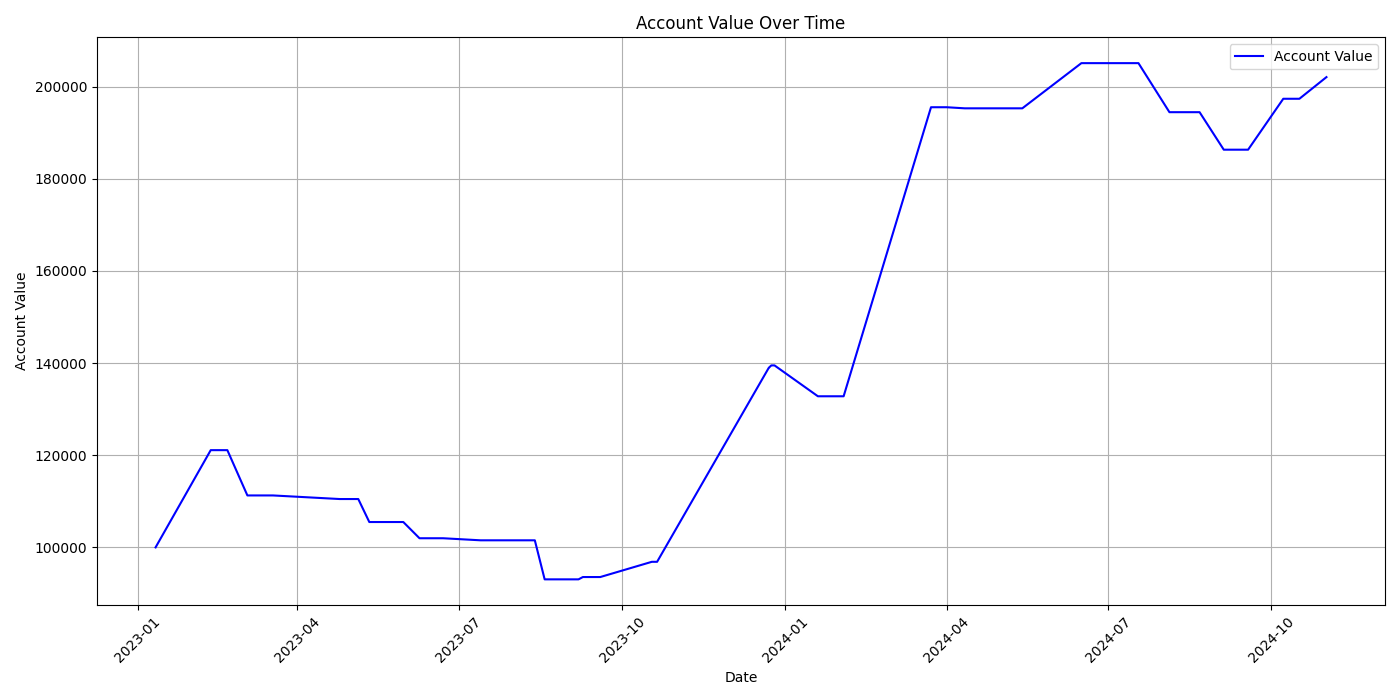

In [24]:
pdf = results.toPandas()

# Plot total portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(pdf['Date'], pdf['Total'], label='Account Value', color='blue')
plt.title('Account Value Over Time')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
%matplot plt

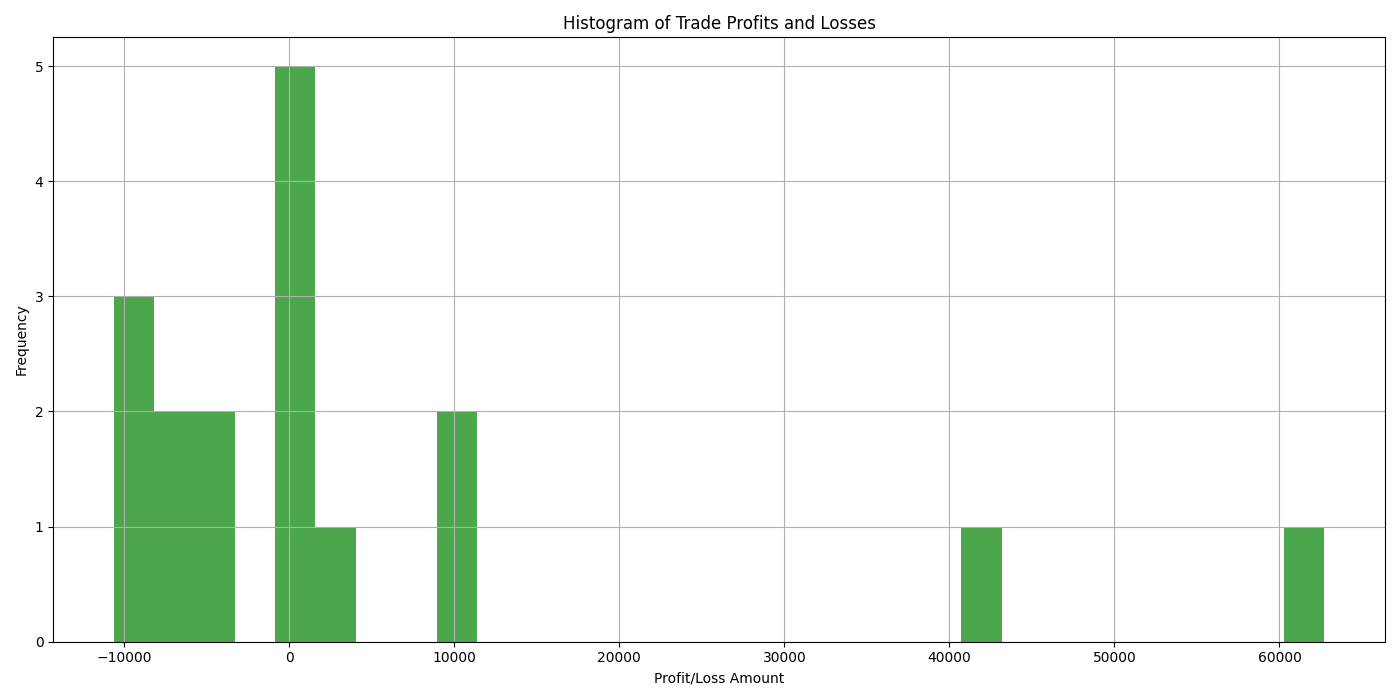

In [25]:
# Plot histogram of profits and losses
profits_losses = pdf[pdf['Action'] == 'sell']['Total'].diff().dropna()  # Calculate profit/loss for each trade
plt.figure(figsize=(14, 7))
plt.hist(profits_losses, bins=30, color='green', alpha=0.7)
plt.title('Histogram of Trade Profits and Losses')
plt.xlabel('Profit/Loss Amount')
plt.ylabel('Frequency')
plt.grid()
plt.tight_layout()
plt.show()
%matplot plt

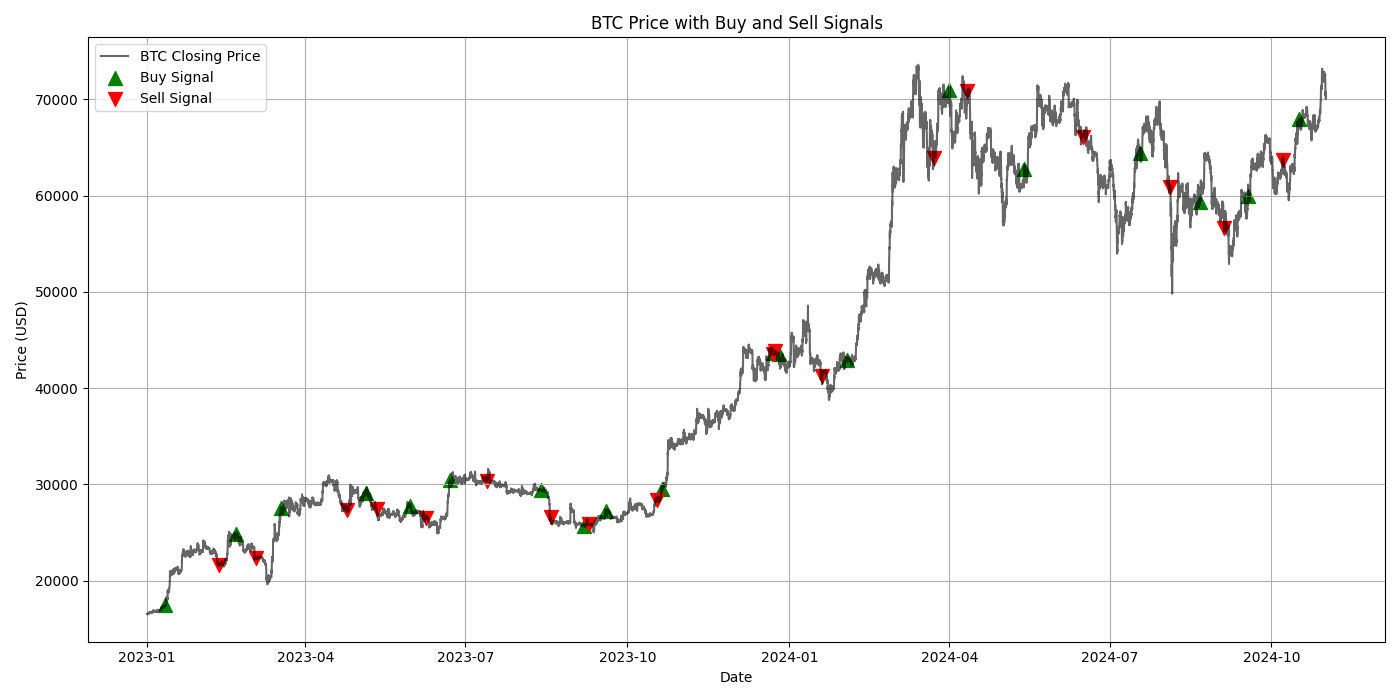

In [26]:
plot_btc_trades(btc_backtest_data, results)
%matplot plt

#### VWAP strategy

In [27]:
btc_backtest_data = btc_processed_data.filter(F.year("close_time") >= 2023)
vwap_results = backtest_strategy(btc_backtest_data, vwap_strategy)
summary = summarize_backtest_results(vwap_results)

In [28]:
print(summary)

{'Total Trades': 8, 'Total Profit/Loss': 25324.98, 'Winning Trades': 3, 'Losing Trades': 5, 'Win/Loss Ratio': 0.6, 'Average Profit/Loss per Trade': 3165.6225}


In [29]:
last_record = vwap_results.orderBy('Date', ascending=False).first()
print(last_record)

Row(Date=datetime.datetime(2024, 10, 31, 23, 59, 59, 999000), Action='end', Price=70292.01, Shares=5, Cash=15339.429999999978, Total=366799.48)


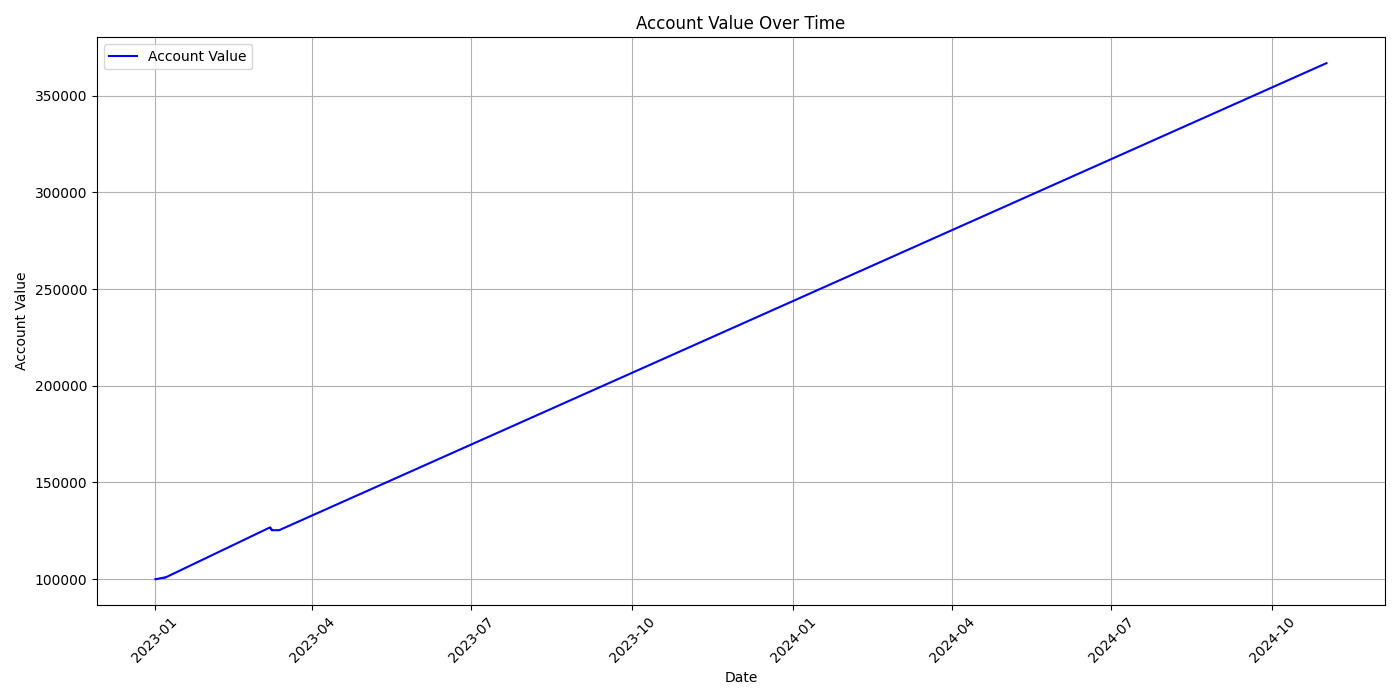

In [30]:
pdf = vwap_results.toPandas()

# Plot total portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(pdf['Date'], pdf['Total'], label='Account Value', color='blue')
plt.title('Account Value Over Time')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
%matplot plt

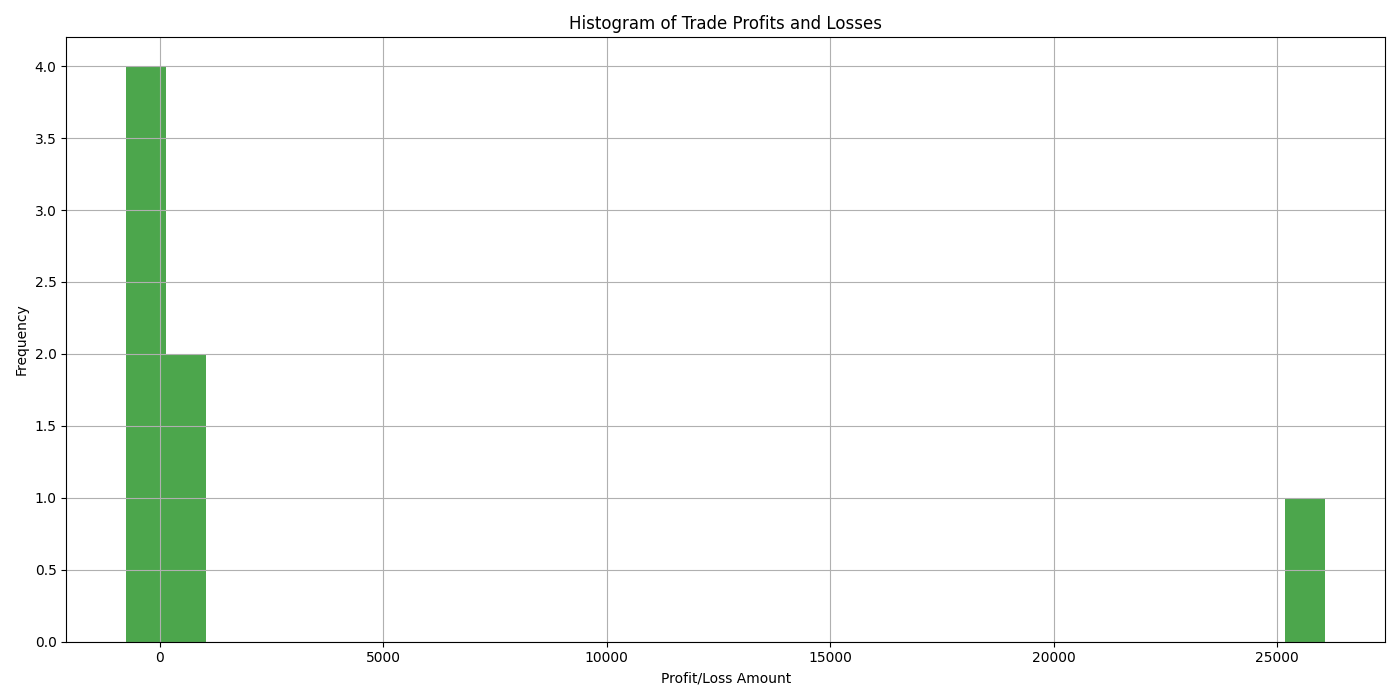

In [31]:
# Plot histogram of profits and losses
profits_losses = pdf[pdf['Action'] == 'sell']['Total'].diff().dropna()  # Calculate profit/loss for each trade
plt.figure(figsize=(14, 7))
plt.hist(profits_losses, bins=30, color='green', alpha=0.7)
plt.title('Histogram of Trade Profits and Losses')
plt.xlabel('Profit/Loss Amount')
plt.ylabel('Frequency')
plt.grid()
plt.tight_layout()
plt.show()
%matplot plt

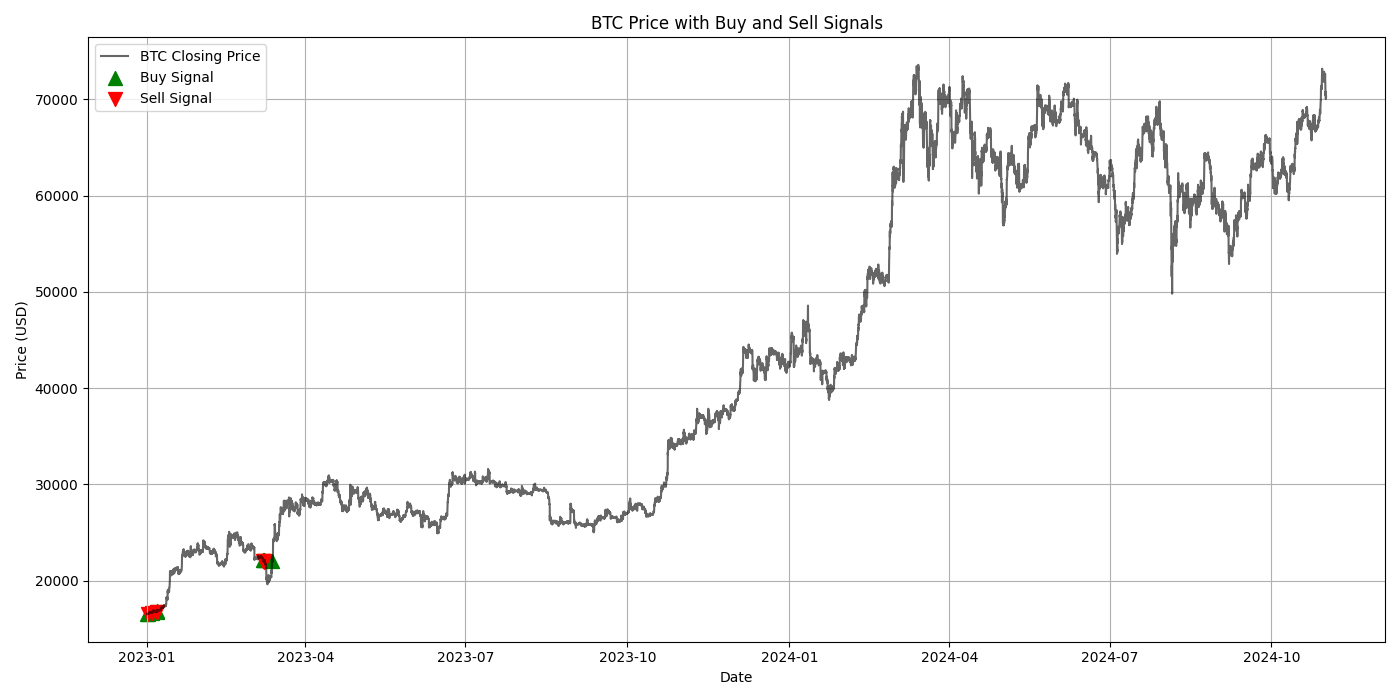

In [32]:
plot_btc_trades(btc_backtest_data, vwap_results)
%matplot plt

#### Linear regression strategy

In [33]:
prediction_backtest = predictions.filter(F.year("close_time") >= 2023)
prediction_backtest = prediction_backtest.join(btc_processed_data.select("close", "close_time"), on="close_time", how="inner")

In [34]:
lr_results = backtest_strategy(prediction_backtest, ML_prediction_strategy)
summary = summarize_backtest_results(lr_results)

In [35]:
print(summary)

{'Total Trades': 194, 'Total Profit/Loss': 94243.64000000017, 'Winning Trades': 120, 'Losing Trades': 74, 'Win/Loss Ratio': 1.6216216216216217, 'Average Profit/Loss per Trade': 485.7919587628875}


In [36]:
last_record = lr_results.orderBy('Date', ascending=False).first()
print(last_record)

Row(Date=datetime.datetime(2024, 10, 31, 22, 59, 59, 999000), Action='end', Price=70480.0, Shares=0, Cash=183410.05000000025, Total=183410.05000000025)


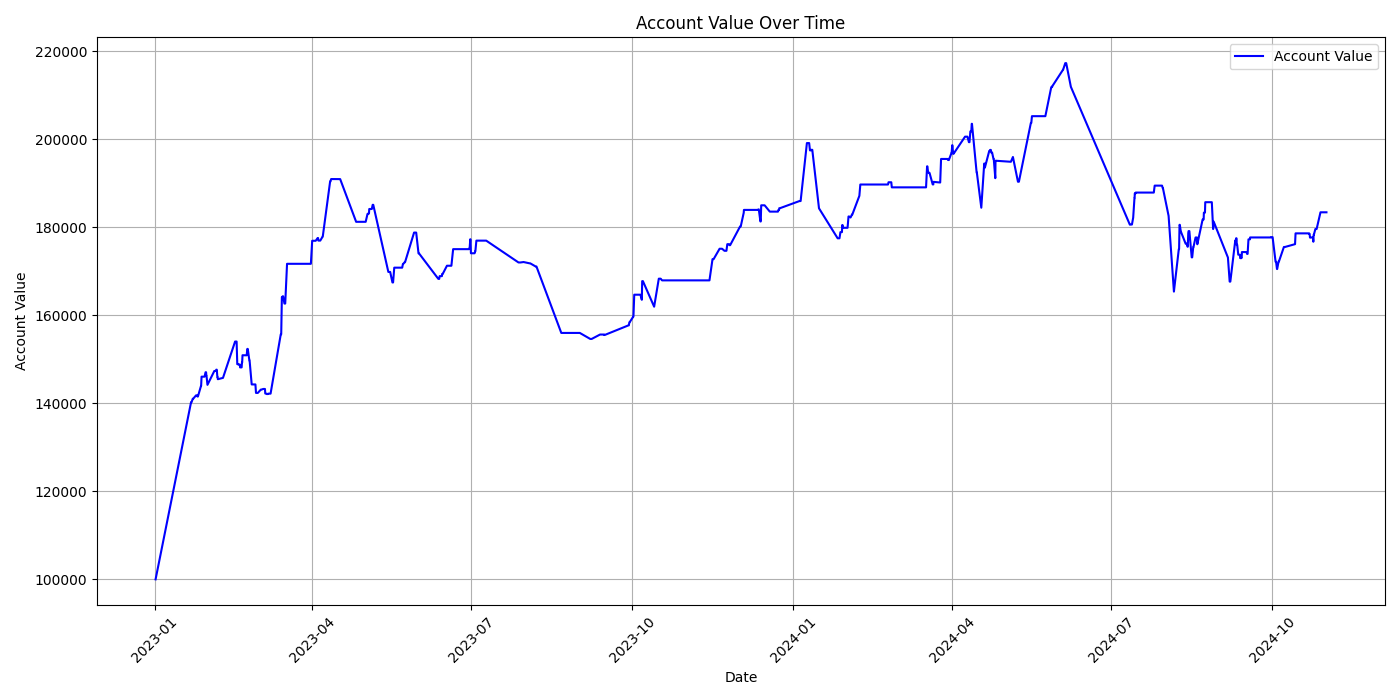

In [37]:
pdf = lr_results.toPandas()

# Plot total portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(pdf['Date'], pdf['Total'], label='Account Value', color='blue')
plt.title('Account Value Over Time')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
%matplot plt

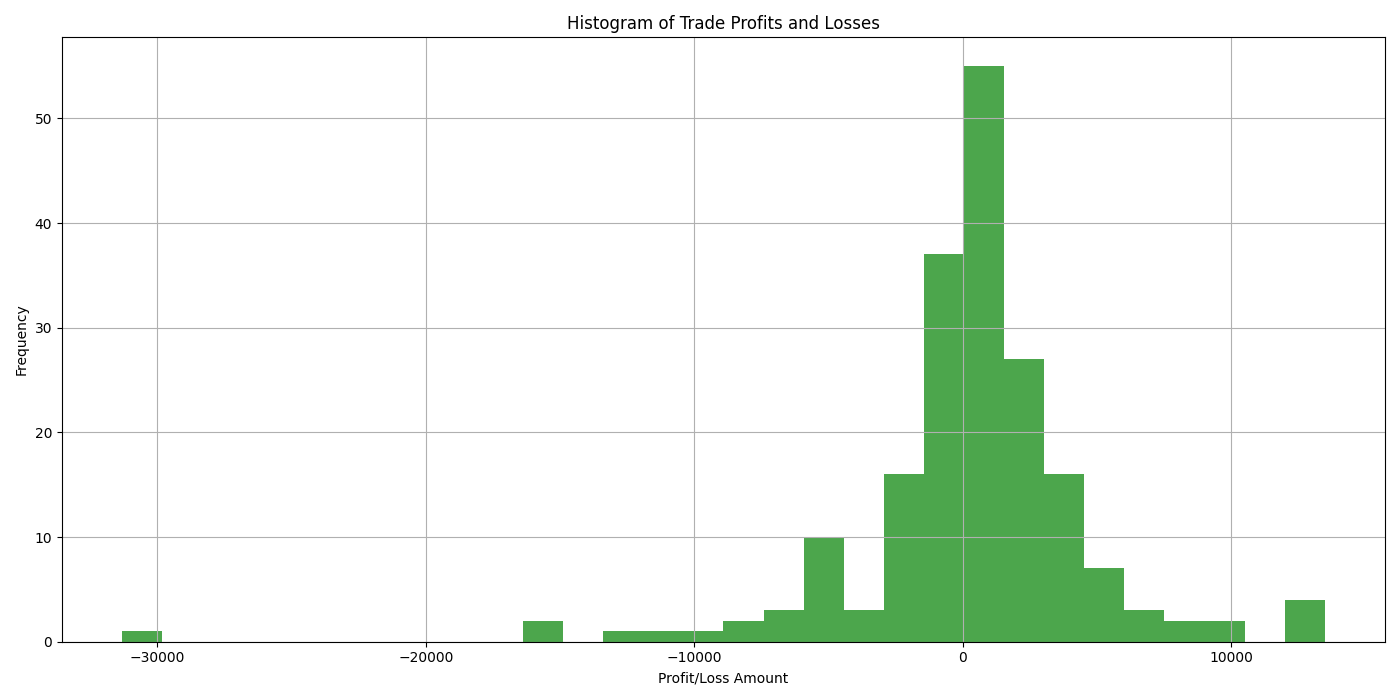

In [38]:
# Plot histogram of profits and losses
profits_losses = pdf[pdf['Action'] == 'sell']['Total'].diff().dropna()  # Calculate profit/loss for each trade
plt.figure(figsize=(14, 7))
plt.hist(profits_losses, bins=30, color='green', alpha=0.7)
plt.title('Histogram of Trade Profits and Losses')
plt.xlabel('Profit/Loss Amount')
plt.ylabel('Frequency')
plt.grid()
plt.tight_layout()
plt.show()
%matplot plt

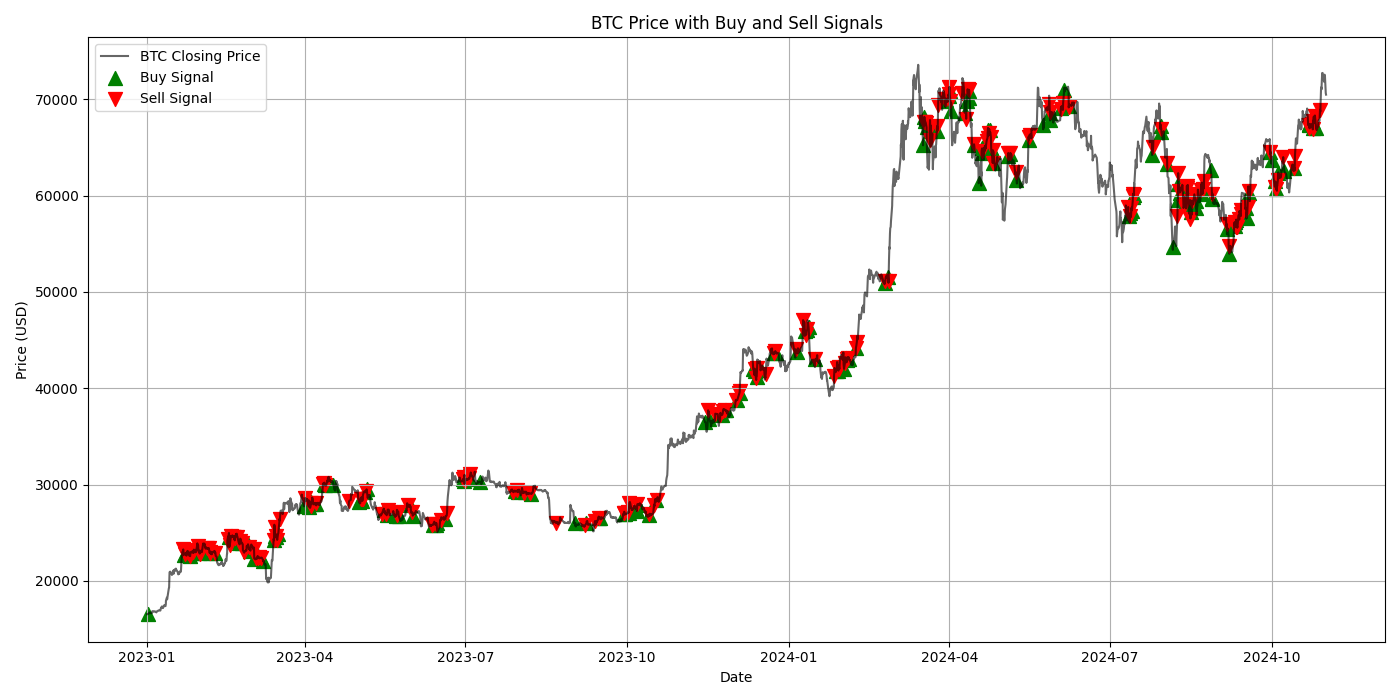

In [39]:
plot_btc_trades(prediction_backtest, lr_results)
%matplot plt

#### Random Forest strategy

In [40]:
prediction_rf_backtest = predictions_rf.filter(F.year("close_time") >= 2023)
prediction_rf_backtest = prediction_rf_backtest.join(btc_processed_data.select("close", "close_time"), on="close_time", how="inner")

In [41]:
rf_results = backtest_strategy(prediction_rf_backtest, ML_prediction_strategy)
summary = summarize_backtest_results(rf_results)

In [69]:
print(summary)

{'Total Trades': 282, 'Total Profit/Loss': 89070.85999999996, 'Winning Trades': 156, 'Losing Trades': 126, 'Win/Loss Ratio': 1.2380952380952381, 'Average Profit/Loss per Trade': 315.85411347517714}


In [42]:
last_record = rf_results.orderBy('Date', ascending=False).first()
print(last_record)

Row(Date=datetime.datetime(2024, 10, 31, 22, 59, 59, 999000), Action='end', Price=70480.0, Shares=0, Cash=166705.9199999999, Total=166705.9199999999)


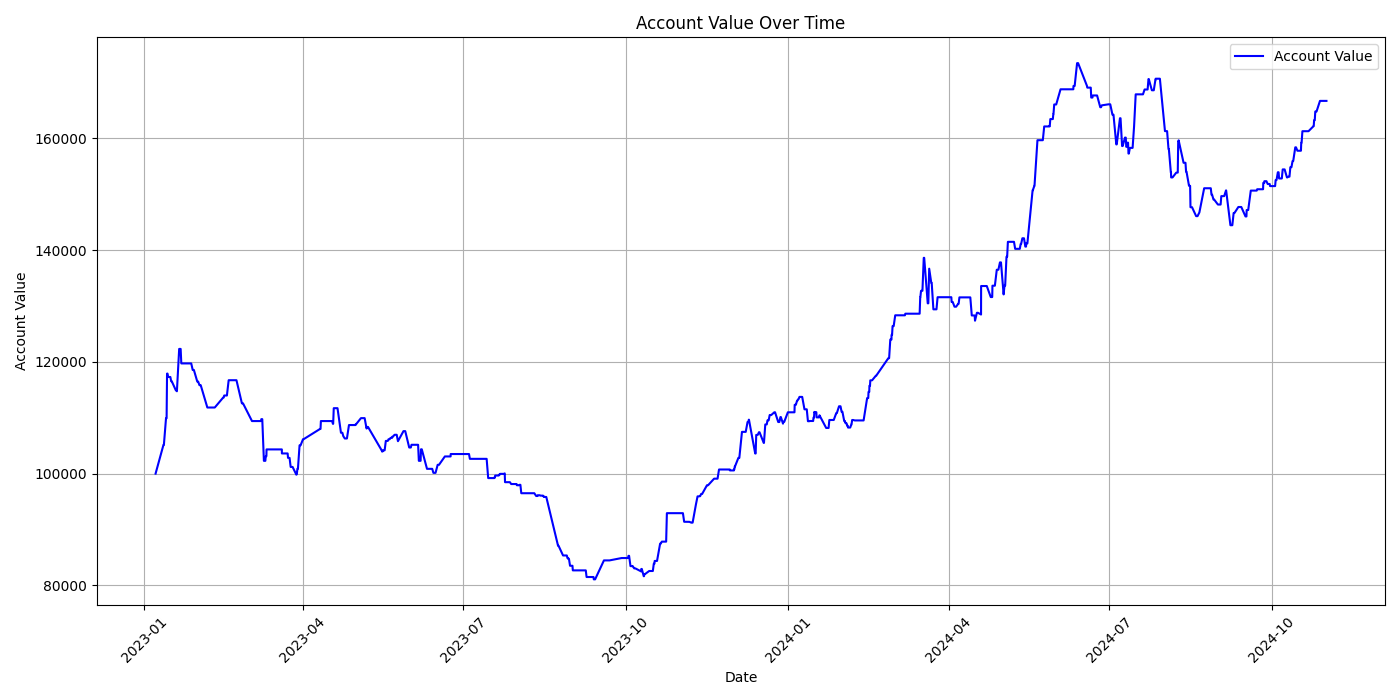

In [43]:
pdf_rf = rf_results.toPandas()

# Plot total portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(pdf_rf['Date'], pdf_rf['Total'], label='Account Value', color='blue')
plt.title('Account Value Over Time')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
%matplot plt

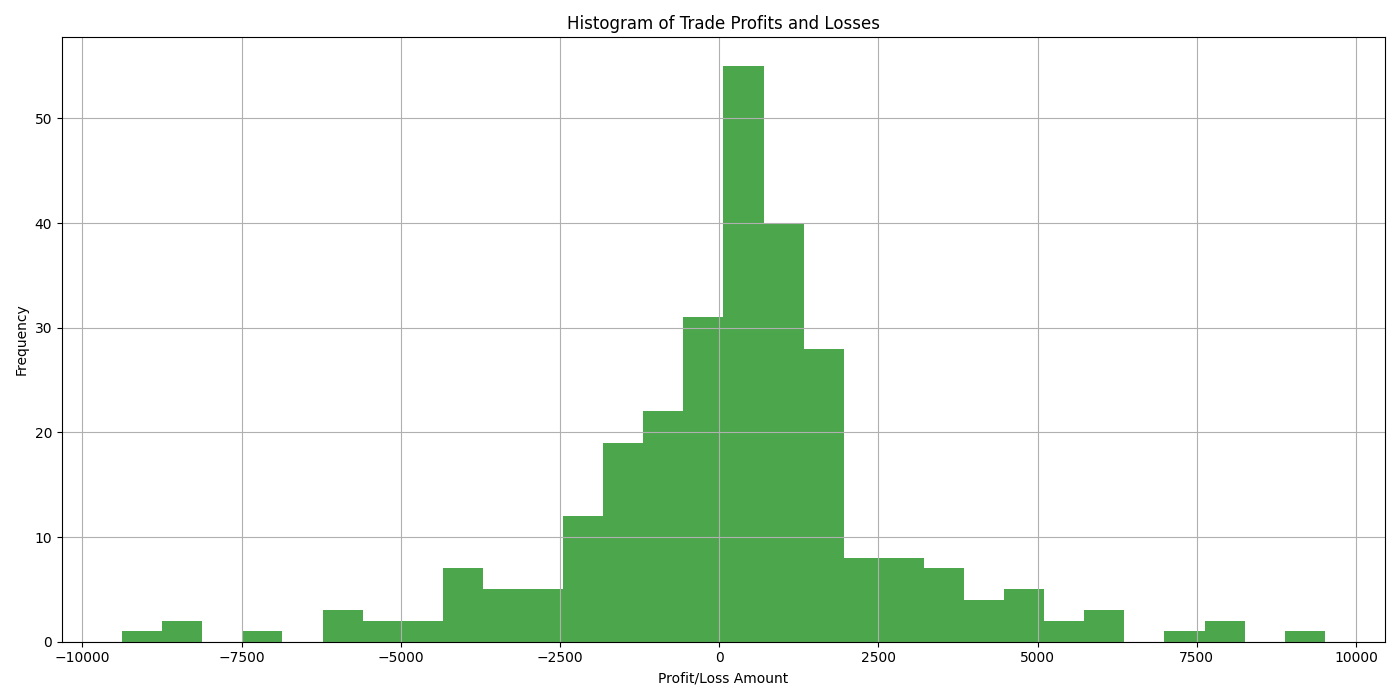

In [45]:
# Plot histogram of profits and losses
profits_losses = pdf_rf[pdf_rf['Action'] == 'sell']['Total'].diff().dropna()  # Calculate profit/loss for each trade
plt.figure(figsize=(14, 7))
plt.hist(profits_losses, bins=30, color='green', alpha=0.7)
plt.title('Histogram of Trade Profits and Losses')
plt.xlabel('Profit/Loss Amount')
plt.ylabel('Frequency')
plt.grid()
plt.tight_layout()
plt.show()
%matplot plt

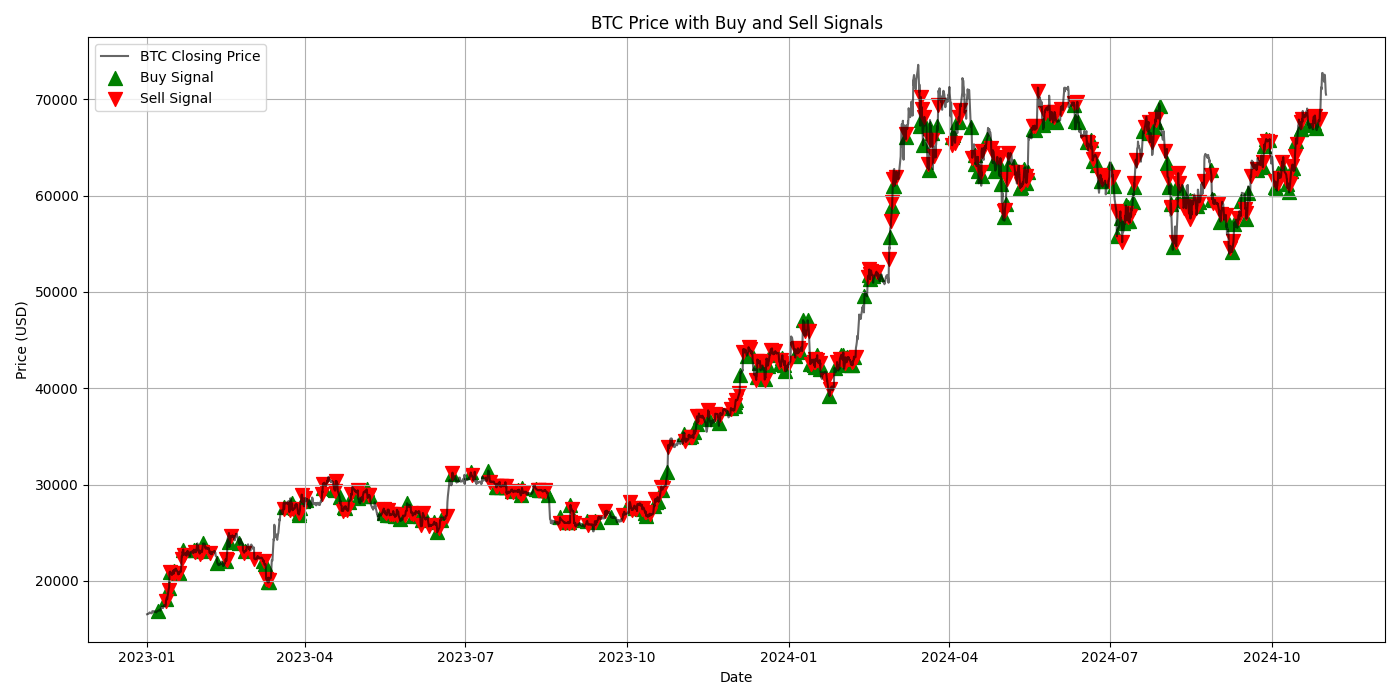

In [46]:
plot_btc_trades(prediction_rf_backtest, rf_results)
%matplot plt

In [4]:
%stop_session

Stopping session: 71c82acc-8155-48d4-a521-6888e377689c
Stopped session.
